In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

In [2]:
img = cv2.imread(os.path.join('demo', 'kover1.jpg'), cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA, img)
# img = cv2.resize(img, (720, 480))
img = ndimage.rotate(img , 0, reshape=True)

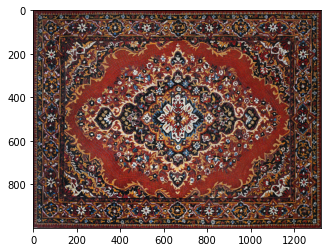

In [3]:
plt.imshow(img)

In [4]:
alpha = 50


In [5]:
from utils.image_transform import warp_perspective, autocrop, rotate_crop, crop_top_image, crop_left_right_borders

In [6]:
from models.create_model import create_model
from data.data_loader import inference_transform
from argparse import Namespace
import torch

opt = Namespace(**{'mode': 'ResNet', 'dataset': 'interiornet', 'gpu_ids':0, 'isTrain': True,
                   'checkpoints_dir': './checkpoints/', 'name':'test_local'})
model = create_model(opt, _isTrain=False)
model.switch_to_train()

./checkpoints/test_local/_best_interiornet_ry_exp_upright_9_sphere_ls_mode_ResnetModel3HeadsSplitNormalizationTightCoupled_lr_0.0004_w_svd_2.0_w_grad_0.25_backprop_eig_1_net_G.pth
---------- Networks initialized -------------
-----------------------------------------------
model [UprightNet] was created


In [7]:
room_img = cv2.imread(os.path.join('demo', 'input_imgs', '12_1.jpg'))
width, height = room_img.shape[1], room_img.shape[0] 

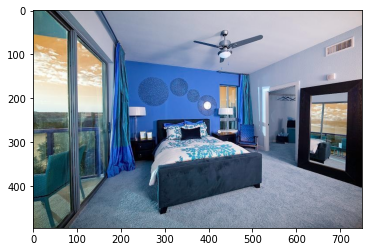

In [8]:
plt.imshow(room_img)

In [9]:
transformed_img = inference_transform({'img': room_img})
est_up_n, pred_roll, pred_pitch = model.infer_model(transformed_img.unsqueeze(0), 1)

In [10]:
print(pred_pitch)

-0.032702645803736455


In [11]:
def compute_angle(pitch):
    if pred_pitch < -0.4:
        angle = max((70 - 65 * (1 + pred_pitch)), 15)
    else:
        angle = max((80 - 65 * (1 + pred_pitch)), 15)
    return angle
    # angle = 10
angle = compute_angle(pred_pitch)
print(angle, pred_pitch)

17.125671977242874 -0.032702645803736455


(190, 1146, 4)


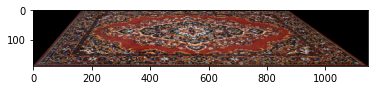

In [12]:
warped, _ = warp_perspective(img, angle)

warped = autocrop(warped)
plt.imshow(warped[...,[0,1,2]])
print(warped.shape)
warped = cv2.resize(warped, (int(warped.shape[1]/5), int(warped.shape[0]/5)))
x_offset= 350
y_offset = 450
alpha_mask = np.zeros([*warped[...,-1].shape, 3], dtype=np.uint8)
alpha_mask[...,0] = warped[...,-1]/255
alpha_mask[...,1] = warped[...,-1]/255
alpha_mask[...,2] = warped[...,-1]/255
result = room_img.copy()
warped_background = result[y_offset:y_offset+warped.shape[0], x_offset:x_offset+warped.shape[1]].copy()
warped_background = np.multiply(warped_background, alpha_mask)
result[y_offset:y_offset+warped.shape[0], x_offset:x_offset+warped.shape[1]] += -warped_background + warped[...,[2,1,0]]


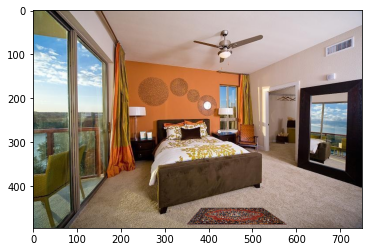

In [13]:
plt.imshow(result[...,::-1])
# cv2.imwrite(os.path.join('demo', 'result', '12_1_carpet.jpg'), result)

In [14]:
texture = cv2.imread(os.path.join('demo', 'wood.jpg'), cv2.IMREAD_UNCHANGED)






In [16]:
mask = cv2.imread(os.path.join('demo', 'input_imgs', '12_mask.png'), cv2.IMREAD_UNCHANGED)[...,::-1] == 3

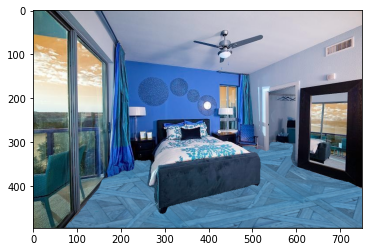

In [30]:
def change_floor_texture(img: np.ndarray, mask: np.ndarray, pitch: float, texture: np.ndarray, texture_angle=0):
    output = img.copy()
    
    angle = compute_angle(pitch)
    texture = rotate_crop(texture , texture_angle)
    warped_texture, _ = warp_perspective(texture, angle)
    warped_texture = autocrop(warped_texture)
    warped_texture = crop_left_right_borders(warped_texture)
    

    croped_mask = crop_top_image(mask)

    texture_h = warped_texture.shape[0] * croped_mask.shape[1]  / warped_texture.shape[1]
    texture_w = croped_mask.shape[1]
    if texture_h > croped_mask.shape[0]:
        warped_texture = cv2.resize(warped_texture, (int(texture_w),
                                                     int(texture_h)))[-croped_mask.shape[0]:,:]
    else:
        texture_h = croped_mask.shape[0]
        texture_w = warped_texture.shape[1] * croped_mask.shape[0]  / warped_texture.shape[0]
        warped_texture = cv2.resize(warped_texture, (int(texture_w),
                                                     int(texture_h)))[:,:croped_mask.shape[1]]
        
    alpha_mask = np.zeros([*mask.shape, 3], dtype=np.uint8)
    alpha_mask[...,0] = mask
    alpha_mask[...,1] = mask
    alpha_mask[...,2] = mask
    result = room_img.copy() - room_img * alpha_mask
    _ = np.zeros([*mask.shape, 3], dtype=np.uint8)
    _[-warped_texture.shape[0]:, result.shape[1]-warped_texture.shape[1]:] = warped_texture
    warped_texture = _
    result[-warped_texture.shape[0]:, result.shape[1]-warped_texture.shape[1]:] += \
                                        warped_texture * alpha_mask
    
    return result
output = change_floor_texture(room_img, mask, pred_pitch, texture, 25)
plt.imshow(output)

In [ ]:
plt.imshow(result[...,::-1])


In [ ]:
plt.imshow(texture)